In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
data = pd.read_csv('customers.csv')

In [144]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [145]:
data.shape

(440, 8)

Wholesale customers dataset has 440 samples with 8 features each.

## Data Exploration

In [148]:
# Drop the channel and Region columns as they have no correlation to customer spending. 
data.drop(['Channel','Region'],axis=1,inplace=True)

In [149]:
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [150]:
data.shape

(440, 6)

Resulting data has 440 samples with 6 features each.

In [151]:
# Display description of the dataset
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
features = data.columns
score_sum = {}

for i in features:
    score_sum[i] = 0.0

for r in range(0,100):
    for i in features:
        target = data[i]
        drop_data = data.drop([i],axis=1)
        X_train,X_test,y_train,y_test = train_test_split(drop_data,target,test_size=0.25,random_state=0)
        
        regressor = DecisionTreeRegressor(random_state=r)
        regressor.fit(X_train,y_train)
        
        score = regressor.score(X_test,y_test)
        score_sum[i] += score


In [154]:
for i in features:
    print(i,score_sum[i]/100)

('Fresh', -0.3538287289410505)
('Milk', 0.22084815730954727)
('Grocery', 0.6224069049961152)
('Frozen', 0.15256665492567806)
('Detergents_Paper', 0.6993323446511885)
('Delicatessen', -12.590140097758699)


I looped over all the features to get the R^2 score for when that feature was dropped.

R^2, is scored between 0 and 1, with 1 being a perfect fit. If a feature having weak usefulness is removed, R^2 will still be closer to 1. That means that the feature is strongly predictable by all other categroies. In other words, we can say that the dropped feature will have strong correlation with the other categories and will not be necessary.

As reported above, I found that dropping Detergents_Paper seems to have the least impact on lowering the R^2 score and hence, I think it is not necessary for identifying customers' spending habits.

In [155]:
# Correlation between the features.
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


### Feature Distributions

C:\Users\tejav\Anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000017BE5898>,
      dtype=object)

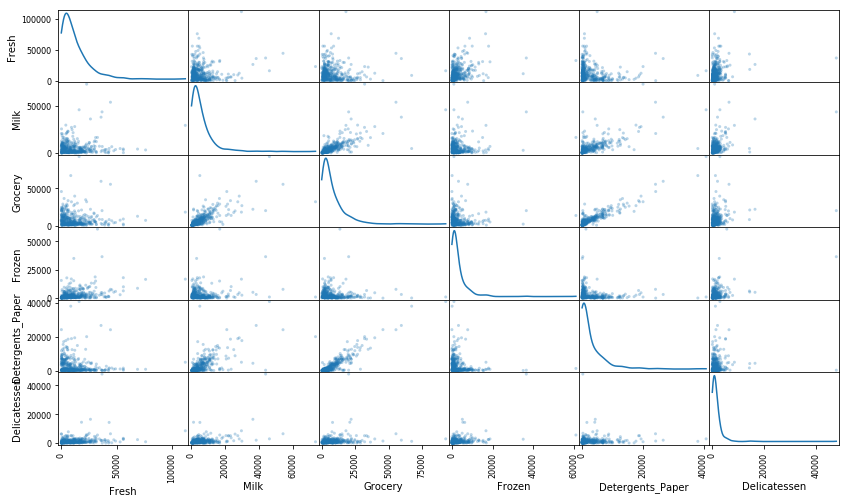

In [156]:
pd.scatter_matrix(data,alpha=0.3,figsize=(14,8),diagonal='kde')

The most visible correlation is between Grocery and Detergents_Paper.I also found them to be most predictable when dropped.

Correlation between Grocery and Milk as well Milk and Detergents_Paper can also been seen.

The data does not appear to be normally distributed and most of the datapoints lie around low values. Due to this skew, we must apply some kind of normalisation to make the features normally distributed since the algorithms we use work under the assumption that the data features are roughly normally distributed

In [157]:
# Feature Scaling 
# Natural Logarithm Scaling
log_data = np.log(data)
log_data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


In [158]:
log_data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,-0.019834,-0.132713,0.383996,-0.155871,0.255186
Milk,-0.019834,1.000000,0.758851,-0.055316,0.677942,0.337833
Grocery,-0.132713,0.758851,1.000000,-0.164524,0.796398,0.235728
Frozen,0.383996,-0.055316,-0.164524,1.000000,-0.211576,0.254718
Detergents_Paper,-0.155871,0.677942,0.796398,-0.211576,1.000000,0.166735
Delicatessen,0.255186,0.337833,0.235728,0.254718,0.166735,1.000000


C:\Users\tejav\Anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000019CFDDA0>,
      dtype=object)

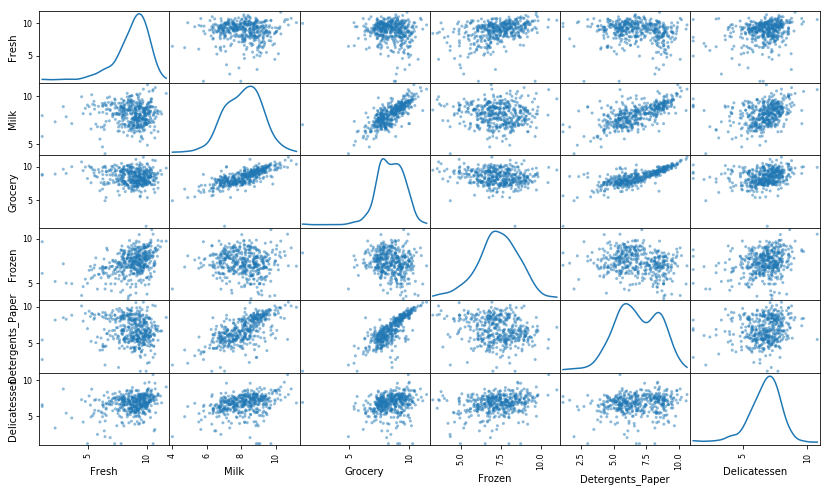

In [159]:
pd.scatter_matrix(log_data,diagonal='kde',figsize=(14,8))

After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

### Outlier Detection
The presence of outliers can often skew results which take into consideration these data points.An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.


In [160]:
# Finding outliers and removing them from the data.
outliers = []
for feature in log_data.keys():
    q1 = np.percentile(log_data[feature],25)
    q3 = np.percentile(log_data[feature],75)
    step = 1.5*(q3-q1)
    
    _outliers = log_data[~((log_data[feature]>=(q1-step))&(log_data[feature]<=(q3+step)))]
    print("Outliers of {}".format(feature))
    display(_outliers)
    
    outliers += [_outliers.index.tolist()]
    unique_outliers = list(set(j for i in outliers for j in i))

good_data = log_data.drop(log_data.index[unique_outliers],axis=0).reset_index(drop=True)


Outliers of Fresh


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Outliers of Milk


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Outliers of Grocery


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Outliers of Frozen


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Outliers of Detergents_Paper


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Outliers of Delicatessen


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


In [161]:
good_data.head()


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


## Feature Transformation

### PCA & Dimensionality Reduction

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. 


In [163]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(good_data)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

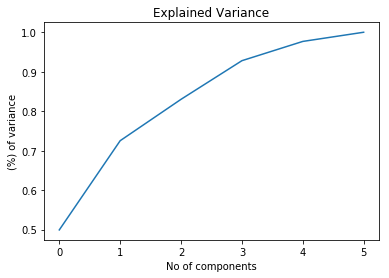

In [164]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No of components')
plt.ylabel('(%) of variance')
plt.title('Explained Variance')
plt.show()

From the observation we can see that 5 components can completely explain the variance of the data.

In [165]:
pca = PCA(n_components=5)
pca.fit(good_data)
reduced_data = pca.transform(good_data)
reduced_data = pd.DataFrame(reduced_data,columns=['Dim1','Dim2','Dim3','Dim4','Dim5'])
reduced_data.head()

,Dim1,Dim2,Dim3,Dim4,Dim5
0,1.779322,-0.660449,-0.824685,1.658016,0.090341
1,1.882034,0.461741,0.276448,0.105548,0.095821
2,1.993507,1.247080,1.215652,0.613369,-0.673209
3,-0.998581,1.369364,0.285448,-0.399707,-0.678070
4,0.993847,2.078314,0.261420,0.522798,-0.498678


## Clustering
Since the scatter plot appears to be quite uniform, a lot of the data points will clearly belong to one or more cluster it would be appropriate to use a GMM in our case.

In [166]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

scores = []
for i in range(2,16):
    clusterer = GaussianMixture(n_components=i,random_state=0)
    clusterer.fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    centers = clusterer.means_
    score = silhouette_score(reduced_data,preds)
    scores += [(score,i)]

In [167]:
scores

[(0.31931660656101857, 2),
 (0.21387781961471683, 3),
 (0.1922525584871487, 4),
 (0.18398512024256303, 5),
 (0.1733910296223961, 6),
 (0.12976026787339692, 7),
 (0.11579798480116915, 8),
 (0.08719479236038441, 9),
 (0.1003552471394723, 10),
 (0.07079874064352347, 11),
 (0.07827309047776092, 12),
 (0.08828576339941333, 13),
 (0.11606643018558334, 14),
 (0.09221793516977897, 15)]

Gaussian Mixture Model with 2 clusters has the best silhouette score of 0.31931660656101857.

### Cluster Visualization

In [168]:
clusterer = GaussianMixture(n_components=2,random_state=0)
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_

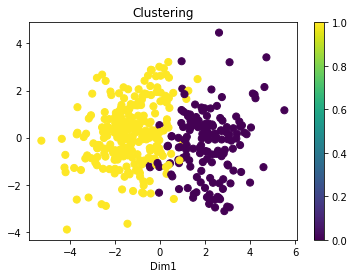

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(reduced_data['Dim1'],reduced_data['Dim2'],c=preds,s=50)
ax.set_title('Clustering')
ax.set_xlabel('Dim1')
ax.set_label('Dim2')
plt.colorbar(scatter)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [170]:
centers

array([[ 2.10177966, -0.26730602, -0.11851336,  0.05229908, -0.07563903],
       [-1.27111024,  0.16166082,  0.07167428, -0.03162933,  0.04574483]])

In [171]:
log_centers = pca.inverse_transform(centers)
true_centers = np.exp(log_centers)

In [172]:
true_centers

array([[ 5820.50654521,  7211.7596773 , 11228.2316251 ,  1009.98135402,
         4633.1181922 ,  1101.53649376],
       [ 8895.29596906,  2122.34748933,  2616.96410336,  2295.20081429,
          326.20497956,   794.93188183]])

In [173]:
segments = ['segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers),columns=data.keys())
true_centers.index = segments
true_centers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
segment 0,5821.0,7212.0,11228.0,1010.0,4633.0,1102.0
segment 1,8895.0,2122.0,2617.0,2295.0,326.0,795.0


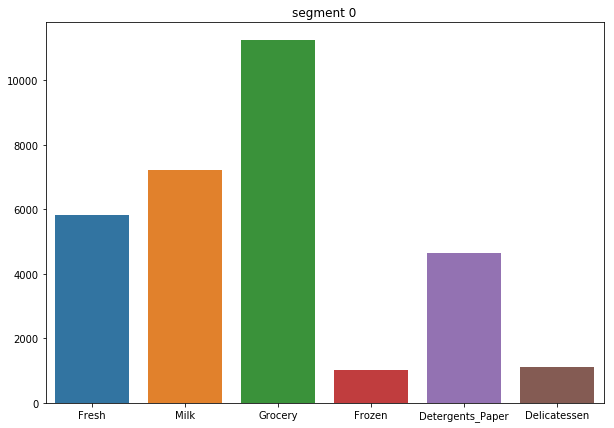

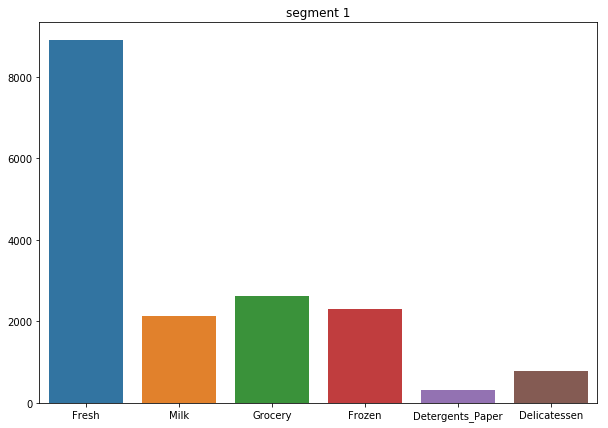

In [174]:
plt.figure(figsize=(10,7))
plt.axes().set_title('segment 0')
sns.barplot(x=true_centers.columns.values,y=true_centers.iloc[0].values)

plt.figure(figsize=(10,7))
plt.axes().set_title('segment 1')
sns.barplot(x=true_centers.columns.values,y=true_centers.iloc[1].values)

Segment 0: This segment represents customers with large purchases of milk, grocery and detergents_paper, i.e. more than 75th percentile of the data. I think this represents cafe/restaurants.

Segment 1: I think this segment represents customers purchasing large quantities of fresh and frozen products, i.e. more than 50th percentile of the data. These are customers who are purchasing in bulk from markets to reduce their expenses.

In [176]:
display(np.exp(good_data).describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.00000
mean,12430.630653,5486.314070,7504.907035,3028.809045,2725.376884,1454.71608
std,12552.698266,6410.878177,9263.803670,3712.563636,4644.023066,1746.45365
min,255.000000,201.000000,223.000000,91.000000,5.000000,46.00000
25%,4043.500000,1597.250000,2125.000000,830.000000,263.250000,448.25000
50%,9108.000000,3611.500000,4573.000000,1729.500000,788.000000,997.50000
75%,16969.000000,6802.500000,9762.250000,3745.000000,3660.500000,1830.00000
max,112151.000000,54259.000000,92780.000000,35009.000000,40827.000000,16523.00000
